In [1]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn import linear_model
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import networkx as nx
from random import shuffle
from networkx.algorithms import bipartite

DATA_FOLDER = "/Users/karunya/Documents/EPFL/ADA/ADA_Group_Tota_Pasari_Prelot/04 - Applied ML/"

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
# import csv data into a dataframe
file = glob.glob(DATA_FOLDER + "lalonde.csv")
df = pd.read_csv(file[0])
df.head()

## Question 1: Propensity score matching

### 1. A naive analysis
#### Compare the distribution of the outcome variable (re78) between the two groups (if subject participated in job training or not), using plots and numbers. To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

#### What might a naive "researcher" conclude from this superficial analysis?

Let's try to look at the dataset

In [ ]:
df.describe()

We observe below that there is no null values

In [ ]:
df.isnull().any()

Let's look at the distribution of the variable of interest


In [ ]:
sns.distplot(df['re78'], fit=stats.expon,kde=False)
# sm.qqplot(data['re78'], line='45')
plt.title('Re78 distribution with EFrom this plots it is hard to discriminate the distribution because the QQ plots have many outliersxponential fit',fontsize=14)
plt.show()

sns.distplot(df['re78'], fit=stats.powerlaw,kde=False)
# sm.qqplot(data['re78'], line='45')
plt.title('Re78 distribution with Power Law fit',fontsize=14)
plt.show()


stats.probplot(df['re78'], dist=stats.expon, sparams=(2),plot=plt)
plt.ylabel('Ordered Values Re78', fontsize=14)
plt.xlabel('Theoritical Quantiles', fontsize=14)
plt.title("Exponential Law Q-Q plot",fontsize=14)
plt.show()

stats.probplot(df['re78'], dist=stats.powerlaw, sparams=(0.8),plot=plt)
plt.title("Power Law Q-Q plot",fontsize=14)
plt.xlabel('Theoritical Quantiles', fontsize=14)
plt.ylabel('Ordered Values Re78', fontsize=14)
plt.show()

From these plots, it is hard to distinguish the distribution because the QQ plots have many outliers. The first representations will focus on categorical covariates. 

In [ ]:
categorical = ['black','hispan','married','nodegree']
for i in categorical:
    sns.boxplot(x=i, y="re78", data=df)
    plt.show()

Then let's look at continous covariate values:

In [ ]:
continous_features = ['age','educ','re74','re75']

In [ ]:
for ft in continous_features:
    plt.scatter(df['re78'], df[ft])
    #plt.title('Feature: %s (jittered)'%(ft))
    plt.xlabel(ft)
    plt.ylabel('Re78')
    plt.show()

Here no linear correlation is found between the continous covaraites and Re78. Regarding education we can try to split it in low and high education

In [ ]:
# education distribution
sns.distplot(df['educ'], kde=False)
plt.show()

We can choose a threshold of 12 years of study, which roughly corresponds to the end of high school (assumption)

In [ ]:
df['educ_thres12'] = 1
df.loc[df['educ'] <12, 'educ_thres12'] = 0

# sns.boxplot(x=i, y#Add the new variable to our table
# plt.show()

We have seen that for the continous covariates no correlation as been seen
Here we try basic statistical analysis. Since the data distribution is not normal and the number of samples is not very big, we use a non parametric test

In [ ]:
# add the new variable to our table
categorical = categorical + ['educ_thres12']

Let's look at the influence of the covariates and how they could bias our score

In [ ]:
for i in categorical:
     print('covariate =',i,' ', stats.ranksums(df['re78'][df[i]==1], df['re78'][df[i]==0]))

In [ ]:
# now we compare the outcome given the treatment: 
print('Effect of the treatment:', stats.ranksums(df['re78'][df['treat']==1], df['re78'][df['treat']==0]))

### Conclusion: 
At a significance level of 0.05, It seems that the African-American origin, the marriage status, and education degree (or abscence of it) have an influence on the salary of the participants. However the job training program (treat) has no significant effect!

### 2. A closer look at the data
#### You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above. You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

#### For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers. As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

#### What do you observe? Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

### 3. A propensity score model

#### Use logistic regression to estimate propensity scores for all points in the dataset. You may use sklearn to fit the logistic regression model and apply it to each data point to obtain propensity scores. Note: you do not need a train/test split here. Train and apply the model on the entire dataset. 

We want to the model with the whole training set to get logistic regression model with x=covariates and y= treatment  

In [ ]:
covariates = df[['age','educ','black','hispan','married','nodegree','re74','re75']]
fn = linear_model.LogisticRegression()

# predict_proba returns the probability of the sample for each class in the model, where classes are ordered as they are in self.classes_.

logistic = fn.fit(covariates, df.treat.ravel()) 
propensity_score=fn.predict_proba(covariates)[:,1] 

In [ ]:
# append the score to the table
df['Propensity_S'] = propensity_score
propensity_score[0:5]

### 4. Balancing the dataset via matching

#### Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group. (Hint: you may explore the networkx package in Python for predefined matching functions.)

#### Your matching should maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

#### After matching, you have as many treated as you have control subjects. Compare the outcomes (re78) between the two groups (treated and control).

#### Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects. What do you observe? Are you closer to being able to draw valid conclusions now than you were before?

In [ ]:
set1 = df['Propensity_S'][df['treat']==0] # control
set2 = df['Propensity_S'][df['treat']==1] # treat 

### 5. Balancing the groups further

### 6. A less naive analysis

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

### Part 1

Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn (link).
TF-IDF, short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using TfidfVectorizer. Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

### Load the 20newsgroups dataset using scikit

In [30]:
import itertools
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.csr import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from pprint import pprint

In [10]:
newsgroups_train = fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))

print("Found {} categories in data".format(len(newsgroups_train.target_names)))
pprint(list(newsgroups_train.target_names))

print("Found {} filenames in data".format(newsgroups_train.filenames.shape))
print("Found {} targets in data". format(newsgroups_train.target.shape))

Found 20 categories in data
['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']
Found (11314,) filenames in data
Found (11314,) targets in data


### Vectorize all the given data using the TF-IDF Vectorizer

In [11]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)

print("Converted text into vectors of shape {}".format(vectors.shape))

Converted text into vectors of shape (11314, 101631)


### The vectors using the vectorizer are sparse and have an average of 97 non-zero components by sample.

In [12]:
print("Number of non-zero components by sample is {}".format(vectors.nnz / float(vectors.shape[0])))

Number of non-zero components by sample is 97.54525366802191


### Before we split the data, we need to pair each label with its corresponding label (the article category).

In [13]:
# create a dictionary mapping from category name to index in the list target_names
category_indices = dict()
for index, key in enumerate(newsgroups_train.target_names):
    category_indices[key] = index

pprint(category_indices)

{'alt.atheism': 0,
 'comp.graphics': 1,
 'comp.os.ms-windows.misc': 2,
 'comp.sys.ibm.pc.hardware': 3,
 'comp.sys.mac.hardware': 4,
 'comp.windows.x': 5,
 'misc.forsale': 6,
 'rec.autos': 7,
 'rec.motorcycles': 8,
 'rec.sport.baseball': 9,
 'rec.sport.hockey': 10,
 'sci.crypt': 11,
 'sci.electronics': 12,
 'sci.med': 13,
 'sci.space': 14,
 'soc.religion.christian': 15,
 'talk.politics.guns': 16,
 'talk.politics.mideast': 17,
 'talk.politics.misc': 18,
 'talk.religion.misc': 19}


In [21]:
# returns the index of the category based on the name extracted from file
def get_category(filenames):
    # for each filename, split by slash and take the filename field which is at index 6
    fields = []
    for filename in filenames:
        field = filename.split("/")[6]
        category_index = category_indices[field]
        fields.append(category_index)
    # return all the fields as a list
    return fields

# get all the corresponding indices for each filename
fields = np.array(get_category(newsgroups_train.filenames))

# create a matrix
category = np.transpose(csr_matrix(fields))
print(fields)

[7 4 4 ..., 3 1 8]


### Split the data into a testing, a validation, and a training set.

In [25]:
# vectors is our x data and targets is our y data
x = vectors
y = newsgroups_train.target

# data_points is the number of rows in x and y data
DATA_POINTS = y.shape[0]

# constants for size of 3 kinds of split datasets
TEST_SIZE = 0.1
VALIDATION_SIZE = 0.1
TRAIN_SIZE = 0.8

indices = list(range(DATA_POINTS))
shuffle(indices)

# calculate range of indices for each of the 3 split datasets
test_range = indices[:int(TEST_SIZE * DATA_POINTS)]
validation_range = indices[int(TEST_SIZE * DATA_POINTS) : int(TEST_SIZE*2 *DATA_POINTS)]
train_range = indices[int(TEST_SIZE*2 *DATA_POINTS):]

x_test = x[test_range]
y_test = y[test_range]

x_validation = x[validation_range]
y_validation = y[validation_range]

x_train = x[train_range]
y_train = y[train_range]

print("Shape of original x and y datasets = {} and {}".format(x.shape, y.shape))
print("Shape of testing x and y datasets = {} and {}".format(x_test.shape, y_test.shape))
print("Shape of validation x and y datasets = {} and {}".format(x_validation.shape, y_validation.shape))
print("Shape of training x and y datasets = {} and {}".format(x_train.shape, y_train.shape))

Shape of original x and y datasets = (11314, 101631) and (11314,)
Shape of testing x and y datasets = (1131, 101631) and (1131,)
Shape of validation x and y datasets = (1131, 101631) and (1131,)
Shape of training x and y datasets = (9052, 101631) and (9052,)


### Part 2

Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the *feature\_importances\_* attribute of your random forest and discuss the obtained results.

### Grid search on the number of estimators and the max depth of the trees

In [ ]:
# best is a dictionary storing all the parameters which give the highest accuracy
best = dict()
best["accuracy"] = 0
best["n_estimators"] = 0
best["max_depth"] = 0

# grid search on the given ranges of n_estimators and max_depth
for n_estimators in range(100, 501, 100):
    for max_depth in range(100, 501, 100):
        # train random forest model using training datasets
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
        clf.fit(x_train, y_train)
        
        # calculate accuracy on validation datasets
        accuracy = accuracy_score(y_validation, clf.predict(x_validation))
        
        # if current accuracy is higher than the highest so far, print
        if accuracy > best["accuracy"]:
            best["n_estimators"] = n_estimators
            best["max_depth"] = max_depth
            best["accuracy"] = accuracy
#             print("Better params found: n_estimators = {} max_depth = {} accuracy = {}"
#                   .format(n_estimators, max_depth, accuracy))

#### On running the above Grid search, we found the best n_estimator to be 300 and the max_depth to be 310

Here are some of the saved results so we don't have to run the grid search again

1. Better params found: n_estimators = 100 max_depth = 10 accuracy = 0.5508399646330681
2. Better params found: n_estimators = 100 max_depth = 110 accuracy = 0.632183908045977
3. Better params found: n_estimators = 100 max_depth = 210 accuracy = 0.6419098143236074
4. Better params found: n_estimators = 200 max_depth = 110 accuracy = 0.6569407603890363
5. Better params found: n_estimators = 300 max_depth = 110 accuracy = 0.6578249336870027
6. Better params found: n_estimators = 300 max_depth = 210 accuracy = 0.6657824933687002
7. Better params found: n_estimators = 300 max_depth = 310 accuracy = 0.6666666666666666

### Print best n_estimators and max_depth found

In [ ]:
# finally printing the best parameters and the highest accuracy
print("Best accuracy found for params: n_estimators = {} max_depth = {} accuracy = {}"
      .format(best["n_estimators"],
              best["max_depth"],
              best["accuracy"]
             ))

### Check accuracy on testing dataset using best parameters to avoid overfitting

In [26]:
# run model using the best parameters
clf = RandomForestClassifier(n_estimators=300, max_depth=310, n_jobs=-1)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

# calculate accuracy on testing dataset
test_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy on testing data = {}".format(test_accuracy))

Accuracy on testing data = 0.6604774535809018
Using params: n_estimators = 0 max_depth = 0 accuracy = 0


### Plot Confusion Matrix

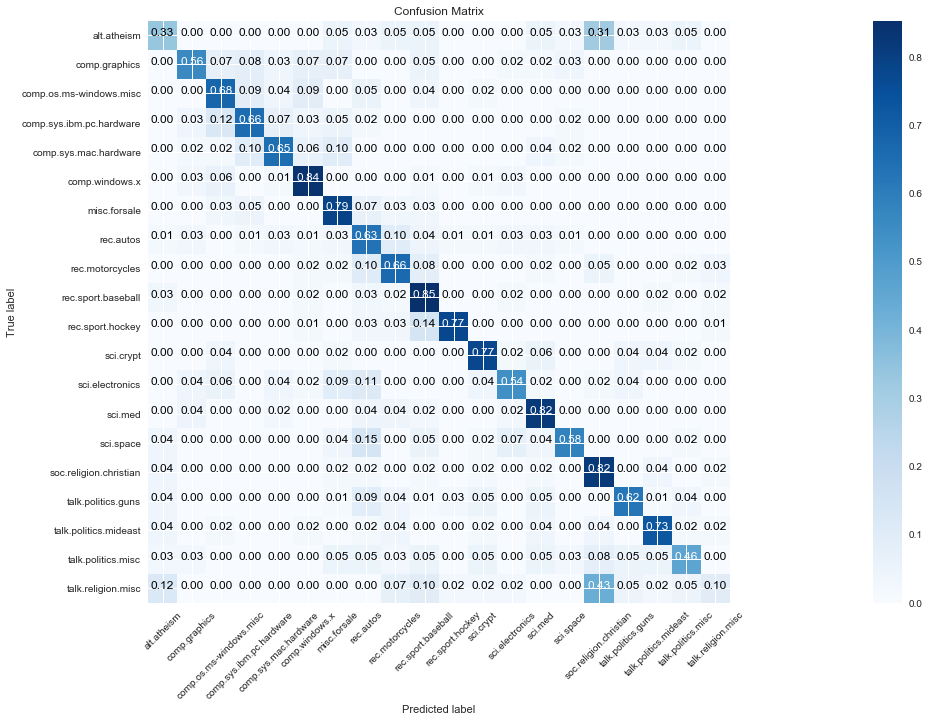

In [34]:
# we plot the confusion matrix here
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(40, 10))

cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(list(newsgroups_train.target_names)))
plt.xticks(tick_marks, list(newsgroups_train.target_names), rotation=45)
plt.yticks(tick_marks, list(newsgroups_train.target_names))

fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()
plt.savefig("Confusion_Matrix.png")

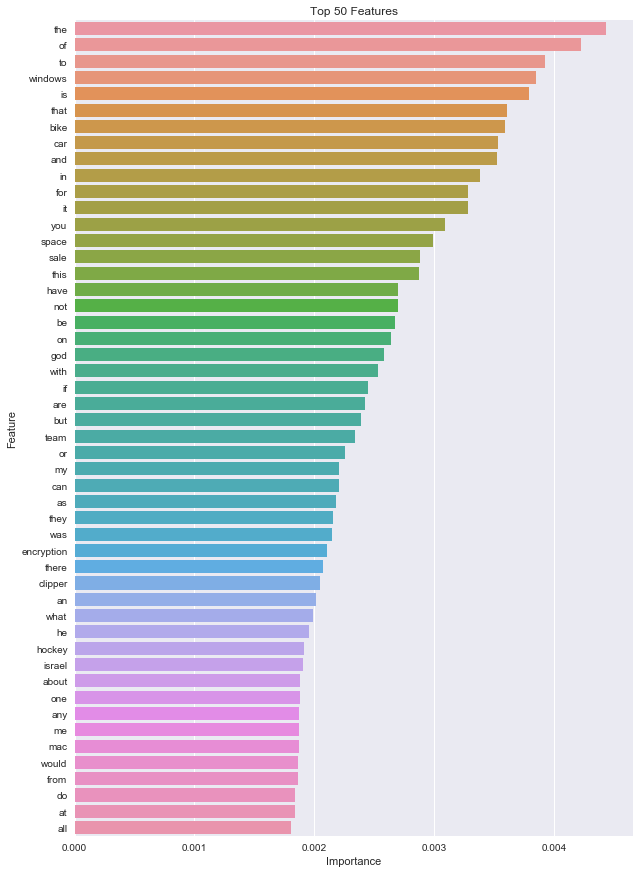

In [41]:
plt.figure(figsize=(10, 15))
features = vectorizer.get_feature_names()

sorted_features = np.array(
                           sorted(zip(
                                clf.feature_importances_.astype(np.float64),
                                features)
                           ))[::-1]

ax = sns.barplot(
        x=sorted_features[:50][:, 0].astype(np.float64),
        y=sorted_features[:50][:, 1])

ax.set_title("Top 50 Features")
ax.set_ylabel("Feature")
ax.set_xlabel("Importance")

plt.show()
plt.savefig("Top_50_Features.png")